# Course Project
### Guilherme Gil, Alva Ringi & Francisco Simões

## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

1.  The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

2. Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

3. Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


In [1]:
# installations that might be needed to run this notebook

# !pip3 install tensorflow
# !pip3 install seaborn
# !pip3 install sklearn

## Load the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [44]:
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix

from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

df = pd.read_csv(COMPAS_INPUT_FILE) # representing data as a dataframe

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


# Part 1: Analysis of the dataset and its biases

- **The dataset contains data on how many convicts?** 

In [41]:
print("There are ", df.shape[0], "samples in the dataset.")

There are  7214 samples in the dataset


- **What are the features the dataset contains?**

In [14]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


<span style="color:red">

__Cleanup the data__

- **Are there missing values (NaN)? are there outliers?**  

hint pandas: check isnull function in pandas

hint dictionary: implement a for and check if the variable is None

- **Does ProPublica mentions how to clean the data?**  

__What is the effect of the following function?__

df = pd.read_csv(COMPAS_INPUT_FILE)

print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
</span>

In [37]:
# pd.isna(df["sex"])
# df["age"].max()
# df = df.dropna(axis=0, how='any', thresh=5, subset=["days_b_screening_arrest"], inplace=False)
# df = df.dropna(subset=["sex", "days_b_screening_arrest"])
# df.shape

(6907, 53)

- **What is the effect of the following code?**

In [18]:
print(df.shape)
df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
df = df[ (df.days_b_screening_arrest <= 30) &
(df.days_b_screening_arrest >= -30) &
(df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A') ]
df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
print(df.shape)

(7214, 53)
(6907, 53)


<span style="color:red">

**Comment**: It first removes all rows in the dataset that have no value for the feature "days before screening arrest". Then it filters out rows that does not full fill the given requirements. This can be used to filter out missing data and outliers. 
</span>

## Basic analysis of demographics

- **What are the different races present in the dataset?** 

In [45]:
df["race"].unique().tolist()

['Other',
 'African-American',
 'Caucasian',
 'Hispanic',
 'Native American',
 'Asian']

- **What is the number of people by age category?**

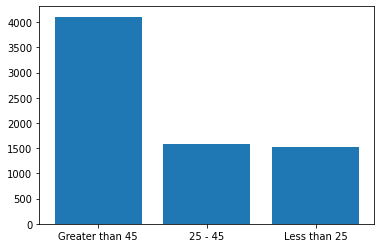

In [46]:
age_cat_names = list(df["age_cat"].unique().tolist())
age_cat_size = list(df.groupby("age_cat").size())
plt.bar(age_cat_names, age_cat_size)
plt.show()

**Comment**: There is a majority of people over 45 years in the dataset.

- **What is the number of people by COMPAS score (decile_score)?**

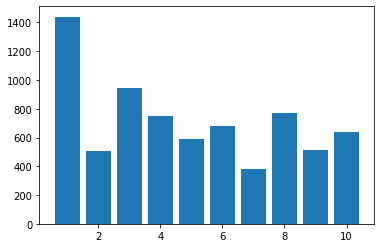

In [47]:
decile_score_names = list(df["decile_score"].unique().tolist())
decile_score_size = list(df.groupby("decile_score").size())
plt.bar(decile_score_names, decile_score_size)
plt.show()

**Comment**: The most common score is 1. For the order scores, the number of people is more even.

- **What is the number of people by COMPAS risk category (score_text)?**

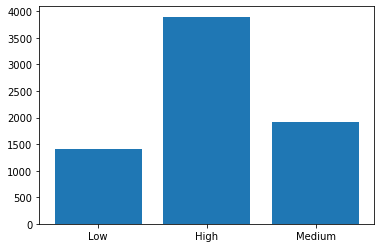

In [54]:
score_text_names = list(df["score_text"].unique().tolist())
score_text_size = list(df.groupby("score_text").size())
plt.bar(score_text_names, score_text_size)
plt.show()

**Comment**: The most common class is "high score". We think this is unexpected since the far most common numerical score is 1. 

- **What is the number of people by race?**

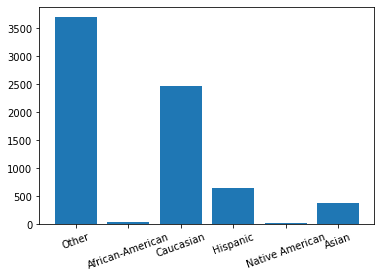

In [52]:
race_names = list(df["race"].unique().tolist())
race_size = list(df.groupby("race").size())
plt.bar(race_names, race_size)
plt.xticks(rotation=20)
plt.show()

**Comment**: There are very few Native American and Asian people in this dataset. We do not think there are enough people in these groups to have an unbiased estimator for them. For this reason, we will remove the categories "Native American" and "Asian" and place these samples in the category "Other". 

In [90]:
df.loc[(df.race == 'Asian'),'race']='Other'
df.loc[(df.race == 'Native American'),'race']='Other'

## Basic investigations of gender and race bias in COMPAS scores

- **What is the mean COMPAS score (decile_score) per race and gender?** 

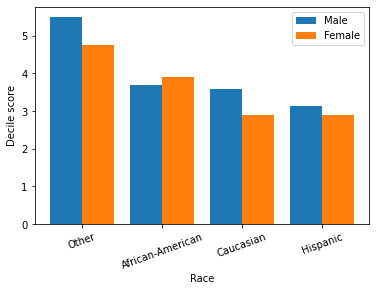

In [91]:
race_names = list(df["race"].unique().tolist())
race_size_female = list(df.loc[df['sex'] == "Female"].groupby(["race","sex"]).mean()["decile_score"])
race_size_male = list(df.loc[df['sex'] == "Male"].groupby(["race","sex"]).mean()["decile_score"])

X_axis = np.arange(len(race_names))
plt.bar(X_axis - 0.2, race_size_male, 0.4, label="Male")
plt.bar(X_axis + 0.2, race_size_female, 0.4, label="Female")
plt.xticks(X_axis, race_names)
plt.xticks(rotation=20)
plt.xlabel("Race")
plt.ylabel("Decile score")
plt.legend()
plt.show()

**Comment**: The decile score is the highest for the race group "other" for both men and women. The decile score does not does not differ that much for men and women of the same race.

- **What is the distribution (histogram) of decile_score per race and gender?**

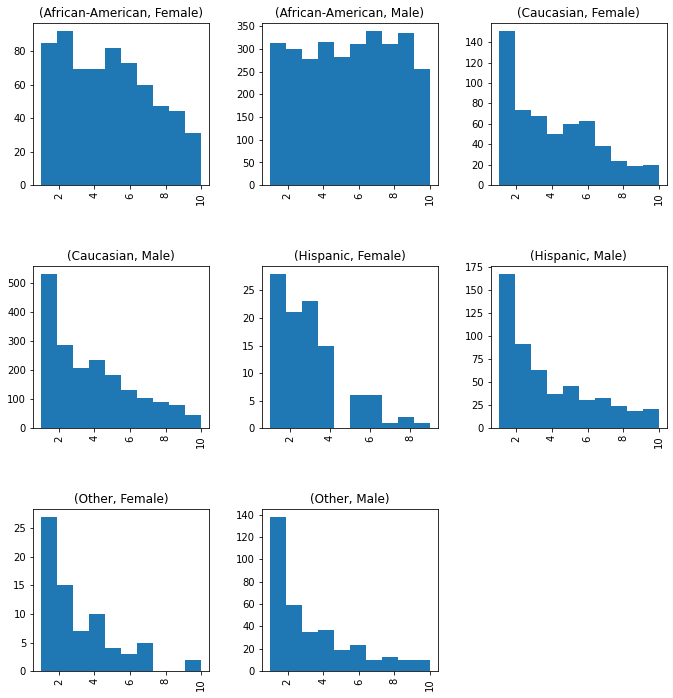

In [92]:
df.hist(column='decile_score', by=["race","sex"],figsize = (11,12));
plt.show()

**Comment**: There seems to be a bias towards African American people since the histogram distribution on this race is more evenly distributed when compared to the other races histograms (we can observe a higher percentage of higher scores in the African American race). For the other races we can see that the  histogram is more squewed to lower values. This applies both for men and women.

- **How many people were re-arrested?** 

In [56]:
rearrested = df[df["two_year_recid"]==1]
print("Number of Re-arrests:", len(rearrested.index))

Number of Re-arrests: 3251


- **Compute the recidivism (i.e., people that got re-arrested) rates by race and gender**

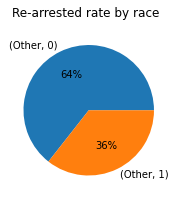

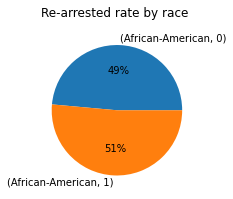

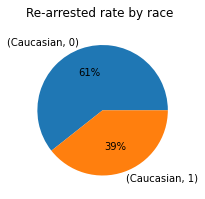

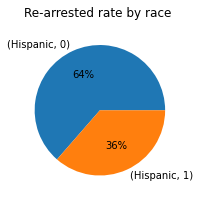

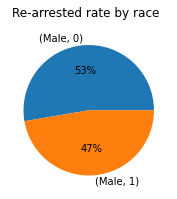

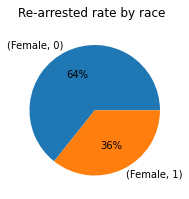

In [93]:
races = df["race"].unique().tolist()

for race in races:
    df.loc[df['race'] == race].groupby(["race","two_year_recid"]).size().plot(kind = "pie", subplots=True , title = "Re-arrested rate by race",autopct='%1.0f%%',label ="", figsize=(3,3)) 
    plt.show()
    
df.loc[df['sex'] == "Male"].groupby(["sex","two_year_recid"]).size().plot(kind = "pie", subplots=True , title = "Re-arrested rate by sex",autopct='%1.0f%%',label ="", figsize=(3,3)) 
plt.show()

df.loc[df['sex'] == "Female"].groupby(["sex","two_year_recid"]).size().plot(kind = "pie", subplots=True , title = "Re-arrested rate by sex",autopct='%1.0f%%',label ="", figsize=(3,3)) 
plt.show()

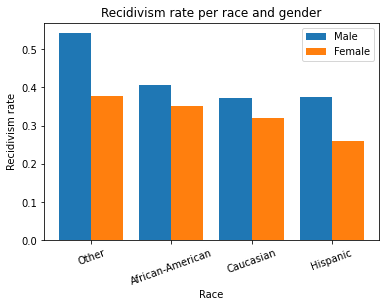

In [135]:
races_names = list(df["race"].unique().tolist())

# calculate number of re-arrested people per race and gender as well as total number of people per race and gender
race_ra_female = list(df.loc[(df['sex'] == "Female") & (df['two_year_recid'] == 1)].groupby(["race","two_year_recid"]).size())
race_nr_female = list(df.loc[(df['sex'] == "Female")].groupby(["race"]).size())
race_ra_male = list(df.loc[(df['sex'] == "Male") & (df['two_year_recid'] == 1)].groupby(["race","two_year_recid"]).size())
race_nr_male = list(df.loc[(df['sex'] == "Male")].groupby(["race"]).size())

# calculate recidivism rate per race and gender by dividing number of re-arrested people by total number of people in each group
race_ra_rate_male = []
race_ra_rate_female = []
for i in range(len(races_names)):
    race_ra_rate_male.append(race_ra_male[i] / race_nr_male[i])
    race_ra_rate_female.append(race_ra_female[i] / race_nr_female[i])


X_axis = np.arange(len(race_names))
plt.bar(X_axis - 0.2, race_ra_rate_male, 0.4, label="Male")
plt.bar(X_axis + 0.2, race_ra_rate_female, 0.4, label="Female")
plt.xticks(X_axis, race_names)
plt.xticks(rotation=20)
plt.xlabel("Race")
plt.ylabel("Recidivism rate")
plt.title("Recidivism rate per race and gender")
plt.legend()
plt.show()

**Comment**: For all races, the recidivism rate is higher for men and women. The recidivism rate is highest for men in the race group "others". For the other groups the recidivism rate is quite similar, around 30-40%. 

In [140]:
dfr = df[["decile_score","two_year_recid","sex","race"]]

# transform decile score [0, 10] to binary by splitting at decile score = 5
def is_recid(row):
    if(row["decile_score"] >= 5):
        return 1
    else:
        return 0
    
dfr['pred_is_recid'] = dfr.apply (lambda row: is_recid(row), axis=1)

/var/folders/pw/jjnmx4s55hg56b5d2ng8cql00000gn/T/ipykernel_85124/1488443751.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr['pred_is_recid'] = dfr.apply (lambda row: is_recid(row), axis=1)


**Comment**: We consider any decile scores equal or above 5 to be a positive recidivism prediction since the decile score goes from 1 to 10.

- **What is the accuracy of the COMPAS scores to predict recidivism**

In [141]:
print("Accuracy: ", accuracy_score(dfr["two_year_recid"], dfr["pred_is_recid"]))

Accuracy:  0.6537288605489326


- **Is the accuracy higher/lower if we look at particular races/genders?**

In [138]:
races = df["race"].unique().tolist()
genders = ["Male","Female"]
for race in races:
    aux_df = dfr.loc[dfr['race'] == race]
    acc = accuracy_score(aux_df["two_year_recid"], aux_df["pred_is_recid"])
    print("Accuracy for {race} is {acc}".format(race = race, acc = acc))

print("")
    
for sex in genders:
    aux_df = dfr.loc[dfr['sex'] == sex]
    acc = accuracy_score(aux_df["two_year_recid"], aux_df["pred_is_recid"])
    print("Accuracy for {sex} is {acc}".format(sex = sex, acc = acc))

Accuracy for Other is 0.6838407494145199
Accuracy for African-American is 0.6382575757575758
Accuracy for Caucasian is 0.6699266503667481
Accuracy for Hispanic is 0.6609105180533752

Accuracy for Male is 0.6537205705447672
Accuracy for Female is 0.6537634408602151


**Comment**: The accuracy seems to be lower for African-Americans than for any other race, which might indicate the existence of some bias. As for gender, both accuracies are similar.

- **What about false positives and false negatives?**

In [142]:
def makeCM (dfr,label):
    cf_matrix = confusion_matrix(dfr["two_year_recid"], dfr["pred_is_recid"])

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix for ' + label);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

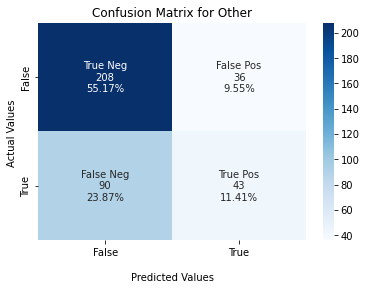

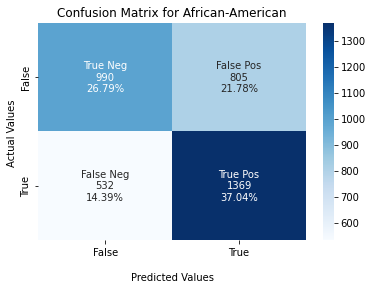

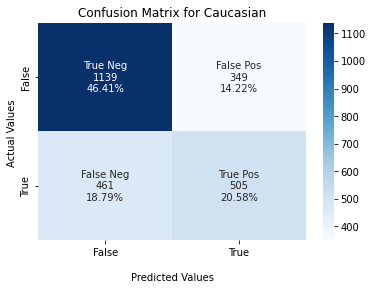

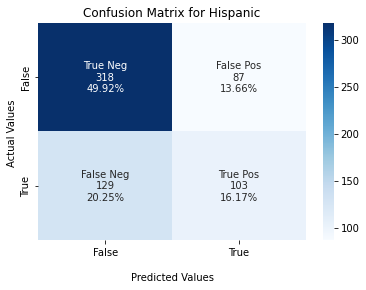

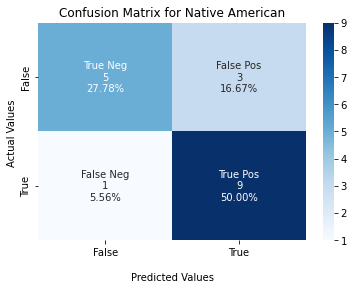

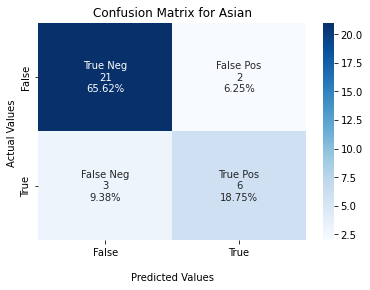

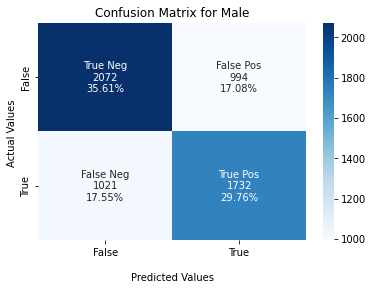

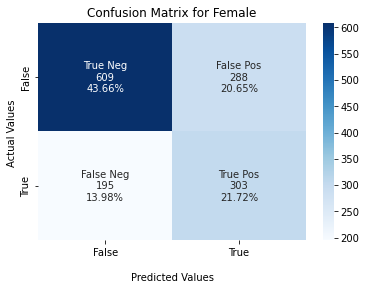

In [8]:
races = df["race"].unique().tolist()
genders = ["Male","Female"]
for race in races:
    aux_df = dfr.loc[dfr['race'] == race]
    makeCM(aux_df,race)  

for sex in genders:
    aux_df = dfr.loc[dfr['sex'] == sex]
    makeCM(aux_df,sex)

**Comment**: From the confusion matrices we can see that the false positive rate is highest among African-Americans indicating that there's a bias against them. The opposite can be found for the other races. The False Negatives is then lower for African-Americans than for other races meaning that the model does a bad job at identifying people that will recomit a crime if they are not African-American.

# Choosing Features

**Comment**: Below we choose what features to use when training our algorithms. We have chosen to use:
- **Sex**: Female, male
- **Age category**: (<25, 25-45, >45 years) 
- **Charge degree**: Misdemeanors, felony
- **Race**: African american, caucasian, hispanic and others (including asian and native american since we have too little data to analyze these races independently)
- **Priors count**: Number of earlier crimes
- **Juvenile mesdemeanor count**: Number of juvenile crimes, misdemeanors
- **Juvenile felony count**: Number of juvenile crimes, felonies
- **Juvenile other count**: Number of juvenile crimes, neither misdemanors nor felonies
- **Two years recid**: Ground truth

Features like e.g. names and dates are not being used since we do not consider them interesting for the prediction. 

We also make all features numerical (using the function "OneHotEncoder") since some algorithms for classifying can only handle numerical data. 

In [144]:
# choose features
dfa = df[["sex","age_cat","race","priors_count","two_year_recid","juv_misd_count","juv_fel_count","juv_other_count","c_charge_degree"]]

In [145]:
# merge race groups "asian" and "native american" with "other"
dfa.loc[(df.race == 'Asian'),'race']='Other'
dfa.loc[(df.race == 'Native American'),'race']='Other'

In [146]:
# make non-numerical features numerical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'age_cat',"c_charge_degree","race"]),
    remainder='passthrough')
d = column_trans.fit_transform(dfa)

In [147]:
# clean lables
labels = column_trans.get_feature_names_out()

def cleanLabels(label):
    if("onehotencoder__" in label):
        return label.removeprefix("onehotencoder__")
    else:
        return label.removeprefix("remainder__")
cleanedLabels = map(cleanLabels,labels)
listedLabels = list(map(cleanLabels,labels))

In [149]:
# create new dataframe with only numerical data
dfa_num = pd.DataFrame(data=d,columns=cleanedLabels)

# Part 2: Train classifiers

**Comment**: Below we randomly split our data into a training set (70% of the dataset) and a test set (30% of the dataset). 

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
Y = dfa_num["two_year_recid"]
X = dfa_num.drop(columns="two_year_recid")

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.30, random_state=42)

In [151]:
def DisplayCM (cf_matrix, label):  
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix for ' + label);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## Logistic Regression

In [152]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test,y_test) # accuracy on test set

0.6877598152424942

In [155]:
# cross validation for logistic regression
scores = []
for c in np.arange (0.01, 1, 0.05):
    clf = LogisticRegression(random_state=0,C = c)
    cv = cross_validate(clf, X_train, y_train, cv=10,scoring='f1_macro')
    score = np.mean(cv["test_score"])
    scores.append([score,c])
reg = max(scores)
clf = LogisticRegression(random_state=0,C = reg[1] ).fit(X_train, y_train)
# predictions = clf.predict(X_test)
log_reg_score = clf.score(X_test,y_test) # accuracy on test set
print("Accuracy on test set for logistic regression: ", log_reg_score)

Accuracy on test set for logistic regression:  0.6877598152424942


In [157]:
# confusion matrices for logistic regression
predictions = clf.predict(X_test)
cm_data = X_test # do we change X_test by doing this? If so, we can't do this
cm_data["two_year_recid"] = y_test
cm_data["predictions"] = predictions # add the predictions to the table with data

#races = cm_data["race"].unique().tolist()
#genders = ["Male","Female"]

#for race in races:
    # aux_df = dfr.loc[dfr['race'] == race]
 #   cm_data_filtered = cm_data.loc[cm_data['race'] == race]
 #   cm = confusion_matrix(cm_data_filtered["two_year_recid"], cm_data_filtered["predictions"])
 #   DisplayCM(cm, race)

#for sex in genders:
    # aux_df = dfr.loc[dfr['sex'] == sex]
    #cm_data_filtered = cm_data.loc[cm_data['race'] == race]
   # cm = confusion_matrix(cm_data_filtered["two_year_recid"], cm_data_filtered["predictions"])
   # makeCM(cm, sex)


cm_data_caucasian = cm_data.loc[dfr['race'] == "Caucasian"]
cm = confusion_matrix(cm_data_caucasian["two_year_recid"], cm_data_caucasian["predictions"])
DisplayCM(cm, "Caucasian")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
- two_year_recid
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 17 features, but LogisticRegression is expecting 15 features as input.

In [ ]:
importance = clf.coef_[0]
# summarize feature importance
j = 0
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.5f' % (listedLabels[j],v))
    j += 1
# plot feature importance
print(len(listedLabels))
print(len(importance))
plt.figure(figsize=(10, 5), dpi=80)
plt.bar(listedLabels[:-1], importance)
plt.rcParams['font.size'] = '25'
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Re-add asians and native americans
#Testing from which number to split from
#we can drop some cols

## SVC

In [ ]:
from sklearn.svm import SVC
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc.fit(X_train, y_train)
svc.score(X_test,y_test)
pred = svc.predict(X_test)
print( "Accuracy " + str(svc.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
scores = []
for c in np.arange (0.01, 1, 0.05):
    svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C = c))
    cv = cross_validate(svc, X_train, y_train, cv=10)
    score = np.mean(cv["test_score"])
    scores.append([score,c])
reg = max(scores)
print(reg)

In [ ]:
best_svc = make_pipeline(StandardScaler(), SVC(gamma='auto',C = reg[1]))
best_svc.fit(X_train, y_train)
pred = best_svc.predict(X_test)
print( "Accuracy " + str(best_svc.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

## Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_scores = []
for k in range(3,12,2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    cv = cross_validate(neigh, X_train, y_train, cv=5)
    k_score = np.mean(cv["test_score"])
    k_scores.append([k_score,k])
k_reg = max(k_scores)
print(k_reg)

In [ ]:
best_neigh = KNeighborsClassifier(n_neighbors=k_reg[1])
best_neigh.fit(X_train, y_train)
pred = best_neigh.predict(X_test)
print( "Accuracy " + str(best_neigh.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
##code from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)


In [ ]:
print(rf_random.best_params_)
rf_random.best_params_["min_samples_leaf"]

In [ ]:
best_rf = RandomForestClassifier(max_depth=rf_random.best_params_["max_depth"], random_state=0, n_estimators=rf_random.best_params_["n_estimators"],min_samples_split=rf_random.best_params_["min_samples_split"],min_samples_leaf=rf_random.best_params_["min_samples_leaf"],max_features=rf_random.best_params_["max_features"],bootstrap=rf_random.best_params_["bootstrap"])
best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
print( "Accuracy " + str(best_rf.score(X_test,y_test)))
f1 = f1_score(y_test, pred, average='macro')
print("F1-Score " + str(f1))

In [ ]:
X.columns

In [ ]:
Index(['sex_Female', 'sex_Male', 'age_cat_25 - 45', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M',
       'race_African-American', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'priors_count', 'two_year_recid', 'juv_misd_count',
       'juv_fel_count', 'juv_other_count'],
      dtype='object')

## Neural Network

In [ ]:
#https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-binary-classification-49596d7dcabf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(64, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, # you can set this to a big number!
                    batch_size=10,
                    validation_data=(X_test,y_test),
                    shuffle=True,
                    verbose=1)



history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
#np.max(val_acc)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

In [ ]:
#analyze each model

# Part 3: Fair classifier

### Definition of fairness

### Building a fair classifier